In [1]:
pip install yfinance --upgrade --no-cache-dir

Note: you may need to restart the kernel to use updated packages.


In [12]:
import yfinance as yf
import pandas as pd
import json
import logging
from datetime import datetime

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def load_tickers_and_dates(json_file_path):
    with open(json_file_path, 'r') as file:
        data = json.load(file)
        tickers = [stock['symbol'] for stock in data['stocks']]
        start_date = data['start_date']
        end_date = data['end_date']
    return tickers, start_date, end_date

def fetch_stock_data(symbol, start_date, end_date):
    try:
        # Fetch data
        df = yf.download(symbol, start=start_date, end=end_date, progress=False)
        
        if df.empty:
            logger.warning(f"No data found for {symbol}")
            return pd.DataFrame()
        
        # Keep only the 'Close' column
        return df[['Close']]
        
    except Exception as e:
        logger.error(f"Error processing {symbol}: {str(e)}")
        return pd.DataFrame()

def main():
    try:
        # Load configuration
        json_file_path = 'tickers.json'
        tickers, start_date, end_date = load_tickers_and_dates(json_file_path)
        
        # Create an empty DataFrame with dates as index
        main_df = pd.DataFrame()
        
        # Fetch and process data
        for symbol in tickers:
            logger.info(f"Fetching data for {symbol}...")
            df = fetch_stock_data(symbol, start_date, end_date)
            if not df.empty:
                # Rename Close column to symbol name
                df = df.rename(columns={'Close': symbol})
                
                if main_df.empty:
                    main_df = df
                else:
                    main_df = main_df.join(df, how='outer')
        
        if not main_df.empty:
            # Sort index by date
            main_df = main_df.sort_index()
            
            # Save dataset
            main_df.to_csv('stock_prices.csv')
            
            logger.info(f"Data saved successfully. Shape: {main_df.shape}")
            logger.info("\nFirst few rows of the data:")
            print(main_df.head())
            
            # Print data coverage
            logger.info(f"\nNumber of trading days: {len(main_df)}")
            logger.info(f"Number of stocks: {len(main_df.columns)}")
            
            # Check for missing values
            missing_pct = (main_df.isnull().sum() / len(main_df) * 100).round(2)
            logger.info("\nPercentage of missing values per stock:")
            print(missing_pct[missing_pct > 0])
            
        else:
            logger.error("No data was processed successfully")
            
    except Exception as e:
        logger.error(f"Main execution error: {str(e)}")
        raise

if __name__ == "__main__":
    main()

2025-01-26 06:39:45,974 - INFO - Fetching data for AAPL...
2025-01-26 06:39:46,012 - INFO - Fetching data for MSFT...
2025-01-26 06:39:46,060 - INFO - Fetching data for GOOGL...
2025-01-26 06:39:46,089 - INFO - Fetching data for NVDA...
2025-01-26 06:39:46,122 - INFO - Fetching data for AMD...
2025-01-26 06:39:46,152 - INFO - Fetching data for CRM...
2025-01-26 06:39:46,183 - INFO - Fetching data for JPM...
2025-01-26 06:39:46,213 - INFO - Fetching data for BAC...
2025-01-26 06:39:46,244 - INFO - Fetching data for GS...
2025-01-26 06:39:46,276 - INFO - Fetching data for MS...
2025-01-26 06:39:46,307 - INFO - Fetching data for V...
2025-01-26 06:39:46,338 - INFO - Fetching data for JNJ...
2025-01-26 06:39:46,369 - INFO - Fetching data for UNH...
2025-01-26 06:39:46,418 - INFO - Fetching data for PFE...
2025-01-26 06:39:46,465 - INFO - Fetching data for ABT...
2025-01-26 06:39:46,512 - INFO - Fetching data for ABBV...
2025-01-26 06:39:46,554 - INFO - Fetching data for AMZN...
2025-01-26 

Price            AAPL       MSFT      GOOGL      NVDA    AMD         CRM  \
Ticker           AAPL       MSFT      GOOGL      NVDA    AMD         CRM   
Date                                                                       
2018-01-02  40.524342  79.633522  53.466679  4.929882  10.98  103.830070   
2018-01-03  40.517288  80.004120  54.378872  5.254335  11.55  104.705177   
2018-01-04  40.705490  80.708260  54.590103  5.282033  12.12  106.087456   
2018-01-05  41.168934  81.708900  55.313984  5.326794  11.88  107.499565   
2018-01-08  41.016018  81.792282  55.509274  5.490012  12.28  108.255348   

Price             JPM        BAC          GS         MS  ...         LIN  \
Ticker            JPM        BAC          GS         MS  ...         LIN   
Date                                                     ...               
2018-01-02  88.111282  25.350628  218.638748  42.214725  ...  139.588013   
2018-01-03  88.201080  25.265839  216.603470  42.327969  ...  140.758774   
2018-01-04 

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import yfinance as yf
from itertools import product

In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def create_sequences(data, time_step=100):
    """
    Create sequences for a single stock
    """
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        sequence = data[i:(i + time_step)]
        target = data[i + time_step]
        X.append(sequence)
        y.append(target)
    return np.array(X), np.array(y)

def build_model(input_shape):
    """
    Build LSTM model for single stock prediction
    """
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(50, return_sequences=True, input_shape=input_shape),
        tf.keras.layers.LSTM(50, return_sequences=False),
        tf.keras.layers.Dense(25),
        tf.keras.layers.Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse')
    return model

def plot_loss(history):
    """
    Plot training and validation loss
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('training_loss.png')
    plt.close()

def main():
    try:
        # Load the data
        logger.info("Loading stock data...")
        # Skip the first 3 rows and use 4th row as headers
        df = pd.read_csv('stock_prices.csv', skiprows=3)
        
        # Convert all columns except Date to float
        for col in df.columns[1:]:  # Skip Date column
            df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Drop any rows with NaN values
        df = df.dropna()
        
        logger.info(f"Data shape after cleaning: {df.shape}")
        
        # Prepare data for all stocks
        all_sequences_X = []
        all_sequences_y = []
        time_step = 100
        
        # Process each stock (skip the Date column)
        for column in df.columns[1:]:  # Skip the Date column
            
            
            # Get stock data and reshape
            stock_data = df[column].values.reshape(-1, 1)
            
            # Skip if not enough data
            if len(stock_data) <= time_step + 1:
                logger.warning(f"Skipping {column}: Not enough data")
                continue
                
            # Scale the data
            scaler = MinMaxScaler(feature_range=(0, 1))
            stock_data_scaled = scaler.fit_transform(stock_data)
            
            # Create sequences
            X, y = create_sequences(stock_data_scaled, time_step)
            
            # Check for NaN values
            if np.isnan(X).any() or np.isnan(y).any():
                logger.warning(f"Skipping {column}: Contains NaN values")
                continue
            
            # Append to main lists
            all_sequences_X.append(X)
            all_sequences_y.append(y)
        
        # Combine all sequences
        X = np.vstack(all_sequences_X)
        y = np.vstack(all_sequences_y)
        
        logger.info(f"Total number of sequences: {len(X)}")
        logger.info(f"X shape: {X.shape}, y shape: {y.shape}")
        
        # Verify no NaN values
        if np.isnan(X).any() or np.isnan(y).any():
            raise ValueError("NaN values found in training data")
        
        # Split the data
        logger.info("Splitting into train and test sets...")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        
        # Build and train the model
        logger.info("Building and training the model...")
        model = build_model((time_step, 1))
        
        # Add early stopping
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
        
        # Train the model
        history = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=100,  # Reduced epochs
            batch_size=32,  # Reduced batch size
            callbacks=[early_stopping],
            verbose=1
        )
        
        # Plot the loss
        logger.info("Plotting loss...")
        plot_loss(history)
        
        # Save the model
        logger.info("Saving model...")
        model.save('stock_prediction_model.h5')
        
        # Model evaluation
        logger.info("Evaluating model...")
        loss = model.evaluate(X_test, y_test, verbose=0)
        logger.info(f'Test Loss: {loss:.4f}')
        
        # Make some sample predictions
        logger.info("Making sample predictions...")
        predictions = model.predict(X_test[:5])
        actuals = y_test[:5]
        
        logger.info("\nSample Predictions vs Actuals (scaled values):")
        for i in range(5):
            logger.info(f"Predicted: {predictions[i][0]:.4f}, Actual: {actuals[i][0]:.4f}")
            
        # Calculate and print mean absolute percentage error for samples
        mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
        logger.info(f"\nMean Absolute Percentage Error for samples: {mape:.2f}%")
        
    except Exception as e:
        logger.error(f"Error during model training: {str(e)}")
        raise

if __name__ == "__main__":
    main()

2025-01-26 07:14:03,581 - INFO - Loading stock data...
2025-01-26 07:14:03,603 - INFO - Data shape after cleaning: (1524, 52)
2025-01-26 07:14:03,691 - INFO - Total number of sequences: 72573
2025-01-26 07:14:03,691 - INFO - X shape: (72573, 100, 1), y shape: (72573, 1)
2025-01-26 07:14:03,696 - INFO - Splitting into train and test sets...
2025-01-26 07:14:03,714 - INFO - Building and training the model...


Epoch 1/100
1815/1815 [==============================] - 87s 47ms/step - loss: 0.0015 - val_loss: 5.5109e-04
Epoch 2/100
1815/1815 [==============================] - 78s 43ms/step - loss: 4.5844e-04 - val_loss: 4.4964e-04
Epoch 3/100
1815/1815 [==============================] - 78s 43ms/step - loss: 3.9995e-04 - val_loss: 3.5510e-04
Epoch 4/100
1815/1815 [==============================] - 77s 42ms/step - loss: 3.9392e-04 - val_loss: 3.8395e-04
Epoch 5/100
1815/1815 [==============================] - 77s 43ms/step - loss: 3.8217e-04 - val_loss: 4.6014e-04
Epoch 6/100
1815/1815 [==============================] - 77s 42ms/step - loss: 3.7405e-04 - val_loss: 3.6318e-04
Epoch 7/100
1815/1815 [==============================] - 77s 42ms/step - loss: 3.7333e-04 - val_loss: 3.5853e-04
Epoch 8/100
1815/1815 [==============================] - 77s 43ms/step - loss: 3.7175e-04 - val_loss: 3.5193e-04
Epoch 9/100
1815/1815 [==============================] - 77s 43ms/step - loss: 3.6707e-04 - val_loss

2025-01-26 07:54:59,318 - INFO - Plotting loss...
2025-01-26 07:54:59,398 - INFO - Saving model...
2025-01-26 07:54:59,414 - INFO - Evaluating model...
2025-01-26 07:55:06,186 - INFO - Test Loss: 0.0004
2025-01-26 07:55:06,187 - INFO - Making sample predictions...


1/1 [==============================] - 0s 403ms/step


2025-01-26 07:55:06,612 - INFO - 
Sample Predictions vs Actuals (scaled values):
2025-01-26 07:55:06,613 - INFO - Predicted: 0.8508, Actual: 0.8133
2025-01-26 07:55:06,613 - INFO - Predicted: 0.8299, Actual: 0.8344
2025-01-26 07:55:06,614 - INFO - Predicted: 0.6703, Actual: 0.6775
2025-01-26 07:55:06,615 - INFO - Predicted: 0.5347, Actual: 0.5022
2025-01-26 07:55:06,615 - INFO - Predicted: 0.4015, Actual: 0.3971
2025-01-26 07:55:06,616 - INFO - 
Mean Absolute Percentage Error for samples: 2.76%


In [76]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def create_sequences(data, time_step=100):
    """
    Create sequences for a single stock
    """
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        sequence = data[i:(i + time_step)]
        target = data[i + time_step]
        X.append(sequence)
        y.append(target)
    return np.array(X), np.array(y)

def build_model(input_shape):
    """
    Build LSTM model for single stock prediction
    """
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(50, return_sequences=True, input_shape=input_shape),
        tf.keras.layers.LSTM(50, return_sequences=False),
        tf.keras.layers.Dense(25),
        tf.keras.layers.Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse')
    return model

def plot_cv_results(cv_histories):
    """
    Plot training results for each CV fold
    """
    plt.figure(figsize=(12, 8))
    
    for fold, history in enumerate(cv_histories):
        plt.plot(history.history['loss'], label=f'Training (Fold {fold+1})')
        plt.plot(history.history['val_loss'], label=f'Validation (Fold {fold+1})')
    
    plt.title('Model Loss During Training (All Folds)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('cv_training_loss.png')
    plt.close()

def train_model_with_cv(X, y, n_splits=3):
    """
    Train model using time series cross-validation
    """
    # Calculate total number of available sequences
    total_sequences = len(X)
    sequences_per_split = total_sequences // n_splits
    
    cv_scores = []
    cv_histories = []
    best_model = None
    best_val_loss = float('inf')
    
    logger.info(f"Total sequences: {total_sequences}")
    logger.info(f"Sequences per split: {sequences_per_split}")
    
    for fold in range(n_splits):
        logger.info(f"\nTraining fold {fold + 1}/{n_splits}")
        
        # Calculate indices for this fold
        val_start = fold * sequences_per_split
        val_end = (fold + 1) * sequences_per_split
        
        # Split the data
        train_indices = list(range(0, val_start)) + list(range(val_end, total_sequences))
        val_indices = list(range(val_start, val_end))
        
        X_train = X[train_indices]
        y_train = y[train_indices]
        X_val = X[val_indices]
        y_val = y[val_indices]
        
        # Build and train model
        model = build_model((100, 1))
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
        
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=10,
            batch_size=32,
            callbacks=[early_stopping],
            verbose=1
        )
        
        # Evaluate on validation set
        val_loss = model.evaluate(X_val, y_val, verbose=0)
        cv_scores.append(val_loss)
        cv_histories.append(history)
        
        logger.info(f"Fold {fold + 1} validation loss: {val_loss:.4f}")
        
        # Keep track of best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model
    
    # Plot results
    plot_cv_results(cv_histories)
    
    # Log CV results
    mean_score = np.mean(cv_scores)
    std_score = np.std(cv_scores)
    logger.info(f"\nCross-validation results:")
    logger.info(f"Mean MSE: {mean_score:.4f} (+/- {std_score:.4f})")
    
    return best_model, cv_scores

def main():
    try:
        # Load the data
        logger.info("Loading stock data...")
        # Skip the first 3 rows and use 4th row as headers
        df = pd.read_csv('stock_prices.csv', skiprows=3)
        
        # Convert all columns except Date to float
        for col in df.columns[1:]:  # Skip Date column
            df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Drop any rows with NaN values
        df = df.dropna()
        
        logger.info(f"Data shape after cleaning: {df.shape}")
        
        # Prepare data for all stocks
        all_sequences_X = []
        all_sequences_y = []
        time_step = 100
        
        # Process each stock (skip the Date column)
        for column in df.columns[1:]:  # Skip the Date column
            logger.info(f"Processing {column}...")
            
            # Get stock data and reshape
            stock_data = df[column].values.reshape(-1, 1)
            
            # Skip if not enough data
            if len(stock_data) <= time_step + 1:
                logger.warning(f"Skipping {column}: Not enough data")
                continue
                
            # Scale the data
            scaler = MinMaxScaler(feature_range=(0, 1))
            stock_data_scaled = scaler.fit_transform(stock_data)
            
            # Create sequences
            X, y = create_sequences(stock_data_scaled, time_step)
            
            # Check for NaN values
            if np.isnan(X).any() or np.isnan(y).any():
                logger.warning(f"Skipping {column}: Contains NaN values")
                continue
            
            # Append to main lists
            all_sequences_X.append(X)
            all_sequences_y.append(y)
        
        # Combine all sequences
        X = np.vstack(all_sequences_X)
        y = np.vstack(all_sequences_y)
        
        logger.info(f"Total number of sequences: {len(X)}")
        logger.info(f"X shape: {X.shape}, y shape: {y.shape}")
        
        # Train model with cross-validation
        best_model, cv_scores = train_model_with_cv(X, y, n_splits=3)
        
        # Save the best model
        logger.info("Saving best model...")
        best_model.save('stock_prediction_model_cv.h5')
        
        # Make some sample predictions
        logger.info("Making sample predictions...")
        predictions = best_model.predict(X[:5])
        actuals = y[:5]
        
        logger.info("\nSample Predictions vs Actuals (scaled values):")
        for i in range(5):
            logger.info(f"Predicted: {predictions[i][0]:.4f}, Actual: {actuals[i][0]:.4f}")
            
        # Calculate and print mean absolute percentage error for samples
        mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
        logger.info(f"\nMean Absolute Percentage Error for samples: {mape:.2f}%")
        
    except Exception as e:
        logger.error(f"Error during model training: {str(e)}")
        raise

if __name__ == "__main__":
    main()

2025-01-26 08:53:28,475 - INFO - Loading stock data...
2025-01-26 08:53:28,497 - INFO - Data shape after cleaning: (1524, 52)
2025-01-26 08:53:28,497 - INFO - Processing 40.52434158325195...
2025-01-26 08:53:28,500 - INFO - Processing 79.6335220336914...
2025-01-26 08:53:28,502 - INFO - Processing 53.466678619384766...
2025-01-26 08:53:28,504 - INFO - Processing 4.929882049560547...
2025-01-26 08:53:28,506 - INFO - Processing 10.979999542236328...
2025-01-26 08:53:28,509 - INFO - Processing 103.83007049560547...
2025-01-26 08:53:28,511 - INFO - Processing 88.11128234863281...
2025-01-26 08:53:28,514 - INFO - Processing 25.350627899169922...
2025-01-26 08:53:28,516 - INFO - Processing 218.6387481689453...
2025-01-26 08:53:28,518 - INFO - Processing 42.214725494384766...
2025-01-26 08:53:28,520 - INFO - Processing 109.10430145263672...
2025-01-26 08:53:28,522 - INFO - Processing 114.76158905029297...
2025-01-26 08:53:28,524 - INFO - Processing 199.3837432861328...
2025-01-26 08:53:28,527

Epoch 1/10
1512/1512 [==============================] - 62s 39ms/step - loss: 0.0016 - val_loss: 6.0801e-04
Epoch 2/10
1512/1512 [==============================] - 59s 39ms/step - loss: 4.7544e-04 - val_loss: 3.6042e-04
Epoch 3/10
1512/1512 [==============================] - 59s 39ms/step - loss: 4.2788e-04 - val_loss: 3.6402e-04
Epoch 4/10
1512/1512 [==============================] - 59s 39ms/step - loss: 4.0477e-04 - val_loss: 3.1553e-04
Epoch 5/10
1512/1512 [==============================] - 59s 39ms/step - loss: 3.9716e-04 - val_loss: 3.1648e-04
Epoch 6/10
1512/1512 [==============================] - 60s 40ms/step - loss: 3.9849e-04 - val_loss: 3.1360e-04
Epoch 7/10
1512/1512 [==============================] - 60s 40ms/step - loss: 3.9428e-04 - val_loss: 3.1693e-04
Epoch 8/10
1512/1512 [==============================] - 61s 41ms/step - loss: 3.9255e-04 - val_loss: 4.0379e-04
Epoch 9/10
1512/1512 [==============================] - 60s 40ms/step - loss: 3.8476e-04 - val_loss: 3.3735e

2025-01-26 09:03:37,647 - INFO - Fold 1 validation loss: 0.0003
2025-01-26 09:03:37,648 - INFO - 
Training fold 2/3


Epoch 1/10
1512/1512 [==============================] - 61s 39ms/step - loss: 0.0015 - val_loss: 3.5993e-04
Epoch 2/10
1512/1512 [==============================] - 59s 39ms/step - loss: 4.4162e-04 - val_loss: 4.0843e-04
Epoch 3/10
1512/1512 [==============================] - 60s 40ms/step - loss: 4.2371e-04 - val_loss: 3.1267e-04
Epoch 4/10
1512/1512 [==============================] - 63s 41ms/step - loss: 4.1303e-04 - val_loss: 3.1607e-04
Epoch 5/10
1512/1512 [==============================] - 63s 41ms/step - loss: 4.0961e-04 - val_loss: 3.4138e-04
Epoch 6/10
1512/1512 [==============================] - 63s 42ms/step - loss: 4.0107e-04 - val_loss: 3.1346e-04
Epoch 7/10
1512/1512 [==============================] - 63s 41ms/step - loss: 3.9717e-04 - val_loss: 3.0749e-04
Epoch 8/10
1512/1512 [==============================] - 65s 43ms/step - loss: 4.0455e-04 - val_loss: 3.1312e-04
Epoch 9/10
1512/1512 [==============================] - 64s 42ms/step - loss: 3.9521e-04 - val_loss: 3.6087e

2025-01-26 09:14:17,160 - INFO - Fold 2 validation loss: 0.0003
2025-01-26 09:14:17,161 - INFO - 
Training fold 3/3


Epoch 1/10
1512/1512 [==============================] - 72s 45ms/step - loss: 0.0022 - val_loss: 8.3180e-04
Epoch 2/10
1512/1512 [==============================] - 69s 45ms/step - loss: 4.2646e-04 - val_loss: 5.6244e-04
Epoch 3/10
1512/1512 [==============================] - 69s 45ms/step - loss: 3.6112e-04 - val_loss: 4.7401e-04
Epoch 4/10
1512/1512 [==============================] - 69s 46ms/step - loss: 3.5793e-04 - val_loss: 5.8188e-04
Epoch 5/10
1512/1512 [==============================] - 69s 45ms/step - loss: 3.4285e-04 - val_loss: 4.3401e-04
Epoch 6/10
1512/1512 [==============================] - 69s 46ms/step - loss: 3.3807e-04 - val_loss: 4.5684e-04
Epoch 7/10
1512/1512 [==============================] - 68s 45ms/step - loss: 3.4171e-04 - val_loss: 4.2492e-04
Epoch 8/10
1512/1512 [==============================] - 68s 45ms/step - loss: 3.4053e-04 - val_loss: 4.2742e-04
Epoch 9/10
1512/1512 [==============================] - 67s 44ms/step - loss: 3.3287e-04 - val_loss: 4.7598e

2025-01-26 09:25:53,671 - INFO - Fold 3 validation loss: 0.0004
2025-01-26 09:25:53,814 - INFO - 
Cross-validation results:
2025-01-26 09:25:53,814 - INFO - Mean MSE: 0.0004 (+/- 0.0000)
2025-01-26 09:25:53,818 - INFO - Saving best model...
2025-01-26 09:25:53,841 - INFO - Making sample predictions...


1/1 [==============================] - 0s 492ms/step


2025-01-26 09:25:54,357 - INFO - 
Sample Predictions vs Actuals (scaled values):
2025-01-26 09:25:54,358 - INFO - Predicted: 0.0650, Actual: 0.0650
2025-01-26 09:25:54,358 - INFO - Predicted: 0.0642, Actual: 0.0644
2025-01-26 09:25:54,359 - INFO - Predicted: 0.0635, Actual: 0.0635
2025-01-26 09:25:54,360 - INFO - Predicted: 0.0626, Actual: 0.0684
2025-01-26 09:25:54,360 - INFO - Predicted: 0.0670, Actual: 0.0707
2025-01-26 09:25:54,360 - INFO - 
Mean Absolute Percentage Error for samples: 2.80%


In [80]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def create_sequences(data, time_step=100):
    """
    Create sequences for a single stock
    """
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        sequence = data[i:(i + time_step)]
        target = data[i + time_step]
        X.append(sequence)
        y.append(target)
    return np.array(X), np.array(y)

def build_model(input_shape):
    """
    Build LSTM model for single stock prediction
    """
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(50, return_sequences=True, input_shape=input_shape),
        tf.keras.layers.LSTM(50, return_sequences=False),
        tf.keras.layers.Dense(25),
        tf.keras.layers.Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse')
    return model

def plot_cv_results(cv_histories):
    """
    Plot training results for each CV fold
    """
    plt.figure(figsize=(12, 8))
    
    for fold, history in enumerate(cv_histories):
        plt.plot(history.history['loss'], label=f'Training (Fold {fold+1})')
        plt.plot(history.history['val_loss'], label=f'Validation (Fold {fold+1})')
    
    plt.title('Model Loss During Training (All Folds)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('cv_training_loss.png')
    plt.close()

def train_model_with_cv(X, y, n_splits=5):
    """
    Train model using time series cross-validation
    """
    # Calculate total number of available sequences
    total_sequences = len(X)
    sequences_per_split = total_sequences // n_splits
    
    cv_scores = []
    cv_histories = []
    best_model = None
    best_val_loss = float('inf')
    
    logger.info(f"Total sequences: {total_sequences}")
    logger.info(f"Sequences per split: {sequences_per_split}")
    
    for fold in range(n_splits):
        logger.info(f"\nTraining fold {fold + 1}/{n_splits}")
        
        # Calculate indices for this fold
        val_start = fold * sequences_per_split
        val_end = (fold + 1) * sequences_per_split
        
        # Split the data
        train_indices = list(range(0, val_start)) + list(range(val_end, total_sequences))
        val_indices = list(range(val_start, val_end))
        
        X_train = X[train_indices]
        y_train = y[train_indices]
        X_val = X[val_indices]
        y_val = y[val_indices]
        
        # Build and train model
        model = build_model((100, 1))
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
        
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=50,
            batch_size=32,
            callbacks=[early_stopping],
            verbose=1
        )
        
        # Evaluate on validation set
        val_loss = model.evaluate(X_val, y_val, verbose=0)
        cv_scores.append(val_loss)
        cv_histories.append(history)
        
        logger.info(f"Fold {fold + 1} validation loss: {val_loss:.4f}")
        
        # Keep track of best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model
    
    # Plot results
    plot_cv_results(cv_histories)
    
    # Log CV results
    mean_score = np.mean(cv_scores)
    std_score = np.std(cv_scores)
    logger.info(f"\nCross-validation results:")
    logger.info(f"Mean MSE: {mean_score:.4f} (+/- {std_score:.4f})")
    
    return best_model, cv_scores

def main():
    try:
        # Load the data
        logger.info("Loading stock data...")
        # Skip the first 3 rows and use 4th row as headers
        df = pd.read_csv('stock_prices.csv', skiprows=3)
        
        # Convert all columns except Date to float
        for col in df.columns[1:]:  # Skip Date column
            df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Drop any rows with NaN values
        df = df.dropna()
        
        logger.info(f"Data shape after cleaning: {df.shape}")
        
        # Prepare data for all stocks
        all_sequences_X = []
        all_sequences_y = []
        time_step = 100
        
        # Process each stock (skip the Date column)
        for column in df.columns[1:]:  # Skip the Date column
            logger.info(f"Processing {column}...")
            
            # Get stock data and reshape
            stock_data = df[column].values.reshape(-1, 1)
            
            # Skip if not enough data
            if len(stock_data) <= time_step + 1:
                logger.warning(f"Skipping {column}: Not enough data")
                continue
                
            # Scale the data
            scaler = MinMaxScaler(feature_range=(0, 1))
            stock_data_scaled = scaler.fit_transform(stock_data)
            
            # Create sequences
            X, y = create_sequences(stock_data_scaled, time_step)
            
            # Check for NaN values
            if np.isnan(X).any() or np.isnan(y).any():
                logger.warning(f"Skipping {column}: Contains NaN values")
                continue
            
            # Append to main lists
            all_sequences_X.append(X)
            all_sequences_y.append(y)
        
        # Combine all sequences
        X = np.vstack(all_sequences_X)
        y = np.vstack(all_sequences_y)
        
        logger.info(f"Total number of sequences: {len(X)}")
        logger.info(f"X shape: {X.shape}, y shape: {y.shape}")
        
        # Train model with cross-validation
        best_model, cv_scores = train_model_with_cv(X, y, n_splits=5)
        
        # Save the best model
        logger.info("Saving best model...")
        best_model.save('stock_prediction_model_cv_big.h5')
        
        # Make some sample predictions
        logger.info("Making sample predictions...")
        predictions = best_model.predict(X[:5])
        actuals = y[:5]
        
        logger.info("\nSample Predictions vs Actuals (scaled values):")
        for i in range(5):
            logger.info(f"Predicted: {predictions[i][0]:.4f}, Actual: {actuals[i][0]:.4f}")
            
        # Calculate and print mean absolute percentage error for samples
        mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
        logger.info(f"\nMean Absolute Percentage Error for samples: {mape:.2f}%")
        
    except Exception as e:
        logger.error(f"Error during model training: {str(e)}")
        raise

if __name__ == "__main__":
    main()

2025-01-26 10:18:20,100 - INFO - Loading stock data...
2025-01-26 10:18:20,123 - INFO - Data shape after cleaning: (1524, 52)
2025-01-26 10:18:20,123 - INFO - Processing 40.52434158325195...
2025-01-26 10:18:20,126 - INFO - Processing 79.6335220336914...
2025-01-26 10:18:20,128 - INFO - Processing 53.466678619384766...
2025-01-26 10:18:20,130 - INFO - Processing 4.929882049560547...
2025-01-26 10:18:20,132 - INFO - Processing 10.979999542236328...
2025-01-26 10:18:20,135 - INFO - Processing 103.83007049560547...
2025-01-26 10:18:20,137 - INFO - Processing 88.11128234863281...
2025-01-26 10:18:20,140 - INFO - Processing 25.350627899169922...
2025-01-26 10:18:20,142 - INFO - Processing 218.6387481689453...
2025-01-26 10:18:20,144 - INFO - Processing 42.214725494384766...
2025-01-26 10:18:20,147 - INFO - Processing 109.10430145263672...
2025-01-26 10:18:20,150 - INFO - Processing 114.76158905029297...
2025-01-26 10:18:20,152 - INFO - Processing 199.3837432861328...
2025-01-26 10:18:20,156

Epoch 1/50
1815/1815 [==============================] - 71s 38ms/step - loss: 0.0018 - val_loss: 4.5658e-04
Epoch 2/50
1815/1815 [==============================] - 69s 38ms/step - loss: 4.6523e-04 - val_loss: 3.0633e-04
Epoch 3/50
1815/1815 [==============================] - 69s 38ms/step - loss: 4.1498e-04 - val_loss: 2.9501e-04
Epoch 4/50
1815/1815 [==============================] - 69s 38ms/step - loss: 4.0569e-04 - val_loss: 3.1100e-04
Epoch 5/50
1815/1815 [==============================] - 69s 38ms/step - loss: 3.9169e-04 - val_loss: 3.8067e-04
Epoch 6/50
1815/1815 [==============================] - 69s 38ms/step - loss: 3.8961e-04 - val_loss: 4.3495e-04
Epoch 7/50
1815/1815 [==============================] - 69s 38ms/step - loss: 3.9037e-04 - val_loss: 2.9621e-04
Epoch 8/50
1815/1815 [==============================] - 69s 38ms/step - loss: 3.8637e-04 - val_loss: 2.8516e-04
Epoch 9/50
1815/1815 [==============================] - 69s 38ms/step - loss: 3.8629e-04 - val_loss: 3.2379e

2025-01-26 10:33:27,786 - INFO - Fold 1 validation loss: 0.0003
2025-01-26 10:33:27,787 - INFO - 
Training fold 2/5


Epoch 1/50
1815/1815 [==============================] - 81s 43ms/step - loss: 0.0014 - val_loss: 5.0468e-04
Epoch 2/50
1815/1815 [==============================] - 80s 44ms/step - loss: 4.4737e-04 - val_loss: 3.5407e-04
Epoch 3/50
1815/1815 [==============================] - 79s 44ms/step - loss: 3.9530e-04 - val_loss: 3.8150e-04
Epoch 4/50
1815/1815 [==============================] - 79s 44ms/step - loss: 3.8782e-04 - val_loss: 4.1281e-04
Epoch 5/50
1815/1815 [==============================] - 79s 44ms/step - loss: 3.7924e-04 - val_loss: 3.4971e-04
Epoch 6/50
1815/1815 [==============================] - 78s 43ms/step - loss: 3.7882e-04 - val_loss: 3.9167e-04
Epoch 7/50
1815/1815 [==============================] - 78s 43ms/step - loss: 3.7312e-04 - val_loss: 3.5950e-04
Epoch 8/50
1815/1815 [==============================] - 78s 43ms/step - loss: 3.7170e-04 - val_loss: 3.4206e-04
Epoch 9/50
1815/1815 [==============================] - 78s 43ms/step - loss: 3.7384e-04 - val_loss: 3.4629e

2025-01-26 10:50:37,808 - INFO - Fold 2 validation loss: 0.0003
2025-01-26 10:50:37,809 - INFO - 
Training fold 3/5


Epoch 1/50
1815/1815 [==============================] - 79s 42ms/step - loss: 0.0015 - val_loss: 5.2295e-04
Epoch 2/50
1815/1815 [==============================] - 76s 42ms/step - loss: 4.4484e-04 - val_loss: 3.5195e-04
Epoch 3/50
1815/1815 [==============================] - 76s 42ms/step - loss: 4.0530e-04 - val_loss: 3.4411e-04
Epoch 4/50
1815/1815 [==============================] - 76s 42ms/step - loss: 3.9679e-04 - val_loss: 4.0706e-04
Epoch 5/50
1815/1815 [==============================] - 76s 42ms/step - loss: 3.8903e-04 - val_loss: 3.2579e-04
Epoch 6/50
1815/1815 [==============================] - 76s 42ms/step - loss: 3.8687e-04 - val_loss: 3.9400e-04
Epoch 7/50
1815/1815 [==============================] - 76s 42ms/step - loss: 3.8309e-04 - val_loss: 3.3696e-04
Epoch 8/50
1815/1815 [==============================] - 76s 42ms/step - loss: 3.8259e-04 - val_loss: 3.6801e-04
Epoch 9/50
1815/1815 [==============================] - 76s 42ms/step - loss: 3.7973e-04 - val_loss: 3.8511e

2025-01-26 11:03:29,451 - INFO - Fold 3 validation loss: 0.0003
2025-01-26 11:03:29,452 - INFO - 
Training fold 4/5


Epoch 1/50
1815/1815 [==============================] - 86s 46ms/step - loss: 0.0015 - val_loss: 4.6282e-04
Epoch 2/50
1815/1815 [==============================] - 78s 43ms/step - loss: 4.1433e-04 - val_loss: 4.2249e-04
Epoch 3/50
1815/1815 [==============================] - 77s 42ms/step - loss: 3.9206e-04 - val_loss: 3.9492e-04
Epoch 4/50
1815/1815 [==============================] - 78s 43ms/step - loss: 3.8232e-04 - val_loss: 3.5544e-04
Epoch 5/50
1815/1815 [==============================] - 77s 43ms/step - loss: 3.7552e-04 - val_loss: 3.6477e-04
Epoch 6/50
1815/1815 [==============================] - 78s 43ms/step - loss: 3.6861e-04 - val_loss: 3.5747e-04
Epoch 7/50
1815/1815 [==============================] - 78s 43ms/step - loss: 3.7212e-04 - val_loss: 3.5600e-04
Epoch 8/50
1815/1815 [==============================] - 78s 43ms/step - loss: 3.6669e-04 - val_loss: 3.8351e-04
Epoch 9/50
1815/1815 [==============================] - 78s 43ms/step - loss: 3.6224e-04 - val_loss: 3.5748e

2025-01-26 11:15:23,239 - INFO - Fold 4 validation loss: 0.0004
2025-01-26 11:15:23,240 - INFO - 
Training fold 5/5


Epoch 1/50
1815/1815 [==============================] - 82s 44ms/step - loss: 0.0016 - val_loss: 5.6208e-04
Epoch 2/50
1815/1815 [==============================] - 78s 43ms/step - loss: 4.0750e-04 - val_loss: 4.3459e-04
Epoch 3/50
1815/1815 [==============================] - 78s 43ms/step - loss: 3.7178e-04 - val_loss: 5.3623e-04
Epoch 4/50
1815/1815 [==============================] - 79s 44ms/step - loss: 3.7103e-04 - val_loss: 4.5967e-04
Epoch 5/50
1815/1815 [==============================] - 79s 44ms/step - loss: 3.6326e-04 - val_loss: 4.3125e-04
Epoch 6/50
1815/1815 [==============================] - 79s 44ms/step - loss: 3.5620e-04 - val_loss: 4.6664e-04
Epoch 7/50
1815/1815 [==============================] - 79s 44ms/step - loss: 3.5329e-04 - val_loss: 4.2909e-04
Epoch 8/50
1815/1815 [==============================] - 79s 44ms/step - loss: 3.4736e-04 - val_loss: 4.3890e-04
Epoch 9/50
1815/1815 [==============================] - 79s 44ms/step - loss: 3.5230e-04 - val_loss: 4.2316e

2025-01-26 11:39:02,838 - INFO - Fold 5 validation loss: 0.0004
2025-01-26 11:39:02,970 - INFO - 
Cross-validation results:
2025-01-26 11:39:02,971 - INFO - Mean MSE: 0.0003 (+/- 0.0000)
2025-01-26 11:39:02,974 - INFO - Saving best model...
2025-01-26 11:39:02,990 - INFO - Making sample predictions...


1/1 [==============================] - 0s 380ms/step


2025-01-26 11:39:03,392 - INFO - 
Sample Predictions vs Actuals (scaled values):
2025-01-26 11:39:03,392 - INFO - Predicted: 0.0674, Actual: 0.0650
2025-01-26 11:39:03,392 - INFO - Predicted: 0.0665, Actual: 0.0644
2025-01-26 11:39:03,393 - INFO - Predicted: 0.0659, Actual: 0.0635
2025-01-26 11:39:03,394 - INFO - Predicted: 0.0651, Actual: 0.0684
2025-01-26 11:39:03,394 - INFO - Predicted: 0.0693, Actual: 0.0707
2025-01-26 11:39:03,395 - INFO - 
Mean Absolute Percentage Error for samples: 3.51%


In [81]:
model = tf.keras.models.load_model('stock_prediction_model_cv_big.h5')

In [82]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 100, 50)           10400     
                                                                 
 lstm_23 (LSTM)              (None, 50)                20200     
                                                                 
 dense_22 (Dense)            (None, 25)                1275      
                                                                 
 dense_23 (Dense)            (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [83]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [84]:
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def visualize_model(model):

    fig, ax = plt.subplots(figsize=(12, 8))


    layer_colors = {
        'LSTM': 'skyblue',
        'Dense': 'lightgreen'
    }


    layer_x = 0
    layer_width = 1.5
    layer_gap = 1.0
    y_center = 5


    for layer in model.layers:
        layer_type = layer.__class__.__name__
        layer_color = layer_colors.get(layer_type, 'lightgrey')
        

        output_shape = layer.output_shape
        if isinstance(output_shape, tuple) and len(output_shape) > 0:
            layer_height = output_shape[-1] / 10.0  
        else:
            layer_height = 1  


        ax.add_patch(Rectangle((layer_x, y_center - layer_height / 2), layer_width, layer_height, edgecolor='black', facecolor=layer_color))


        ax.text(layer_x + layer_width / 2, y_center + layer_height / 2 + 0.1, layer_type, ha='center', va='bottom', fontsize=12, fontweight='bold')
        ax.text(layer_x + layer_width / 2, y_center - layer_height / 2 - 0.1, f"Output: {output_shape}", ha='center', va='top', fontsize=10)


        layer_x += layer_width + layer_gap


    ax.set_xlim(-1, layer_x)
    ax.set_ylim(y_center - 10, y_center + 10)
    ax.axis('off')
    plt.title("Model Architecture")
    plt.show()

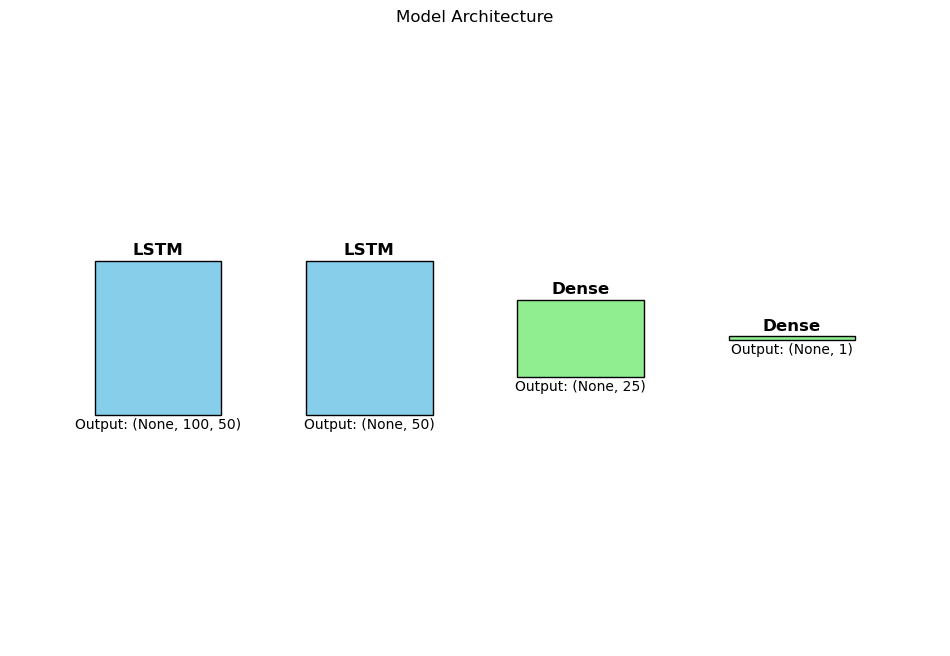

In [85]:
visualize_model(model)

In [86]:

def predict_stock_price(ticker, days_to_predict):

    model = tf.keras.models.load_model('model.h5')


    stock_data = yf.download(ticker, period="1y")
    data = stock_data['Close'].values.reshape(-1, 1)


    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)


    time_step = 100
    X, y = create_dataset(data_scaled, time_step)
    X = X.reshape(X.shape[0], X.shape[1], 1)


    predictions = []
    last_sequence = X[-1]

    for _ in range(days_to_predict):
        prediction = model.predict(last_sequence.reshape(1, time_step, 1))
        predictions.append(prediction[0, 0])
        last_sequence = np.append(last_sequence[1:], prediction).reshape(time_step, 1)


    predictions = np.array(predictions).reshape(-1, 1)
    predictions_original_scale = scaler.inverse_transform(predictions)

    return predictions_original_scale



In [87]:
def predict_stock_price_bullish(ticker, days_to_predict, randomness=0.01):
    # Fetch historical stock data
    stock_data = yf.download(ticker, period="1y")
    data = stock_data['Close'].values.reshape(-1, 1)


    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)


    time_step = 100
    X, y = create_dataset(data_scaled, time_step)
    X = X.reshape(X.shape[0], X.shape[1], 1)


    predictions = []
    last_sequence = X[-1]

    for _ in range(days_to_predict):
        prediction = model.predict(last_sequence.reshape(1, time_step, 1))

        prediction = prediction + (np.random.rand() * randomness)
        predictions.append(prediction[0, 0])
        last_sequence = np.append(last_sequence[1:], prediction).reshape(time_step, 1)


    predictions = np.array(predictions).reshape(-1, 1)
    predictions_original_scale = scaler.inverse_transform(predictions)

    return predictions_original_scale

In [88]:
def predict_stock_price_bearish(ticker, days_to_predict, randomness=0.01):

    stock_data = yf.download(ticker, period="1y")
    data = stock_data['Close'].values.reshape(-1, 1)


    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)


    time_step = 100
    X, y = create_dataset(data_scaled, time_step)
    X = X.reshape(X.shape[0], X.shape[1], 1)


    predictions = []
    last_sequence = X[-1]

    for _ in range(days_to_predict):
        prediction = model.predict(last_sequence.reshape(1, time_step, 1))

        prediction = prediction - (np.random.rand() * randomness)
        predictions.append(prediction[0, 0])
        last_sequence = np.append(last_sequence[1:], prediction).reshape(time_step, 1)


    predictions = np.array(predictions).reshape(-1, 1)
    predictions_original_scale = scaler.inverse_transform(predictions)

    return predictions_original_scale

In [89]:
def generate_predictions(tickers, days_to_predict, randomness=0.01):
    predictions = {}
    for ticker in tickers:
        bullish_price = predict_stock_price_bullish(ticker, days_to_predict, randomness)[-1, 0]
        bearish_price = predict_stock_price_bearish(ticker, days_to_predict, randomness)[-1, 0]
        current_price = yf.Ticker(ticker).history(period='1d')['Close'][0]
        predicted_price = predict_stock_price(ticker, days_to_predict)[-1, 0]
        predictions[ticker] = [bullish_price, bearish_price, current_price, predicted_price]
    return predictions

In [90]:
def calculate_percent_change(predictions):
    percent_changes = {}
    for ticker, prices in predictions.items():
        bullish_price, bearish_price, current_price, predicted_price = prices
        bullish_change = ((bullish_price - current_price) / current_price) * 100
        bearish_change = ((bearish_price - current_price) / current_price) * 100
        predicted_change = ((predicted_price - current_price) / current_price) * 100
        percent_changes[ticker] = [bullish_change, bearish_change, predicted_change]
    return percent_changes

In [91]:
def stock_selection(percent_changes, allowable_change):
    selected_stocks = {}
    for ticker, changes in percent_changes.items():
        bullish_change, bearish_change, predicted_change = changes
        if bullish_change >= allowable_change and bearish_change >= allowable_change and predicted_change >= allowable_change:
            selected_stocks[ticker] = changes
    return selected_stocks

In [92]:
#heurystyki wybierania portfolio:

In [93]:
def greedy(scenario, tickers, current_prices, investment_budget, biggest_allowable_net_loss):
    num_shares = [0] * len(tickers)
    remaining_budget = investment_budget
    remaining_allowable_loss = biggest_allowable_net_loss
    total_invested = 0
    total_loss = 0


    potential_gains = {tickers[i]: scenario[i] - current_prices[i] for i in range(len(tickers))}


    sorted_stocks = sorted(potential_gains.items(), key=lambda item: item[1], reverse=True)

    for ticker, gain in sorted_stocks:
        index = tickers.index(ticker)
        current_price = current_prices[index]
        predicted_price = scenario[index]


        max_shares_by_budget = remaining_budget // current_price
        max_shares_by_loss = remaining_allowable_loss // max(1, current_price - predicted_price)
        max_shares = min(max_shares_by_budget, max_shares_by_loss)

        if max_shares > 0:
            num_shares[index] = max_shares
            invested_amount = max_shares * current_price
            total_invested += invested_amount
            if predicted_price < current_price:
                total_loss += max_shares * (current_price - predicted_price)
            remaining_budget -= invested_amount
            remaining_allowable_loss -= invested_amount

    return num_shares, total_invested, total_loss

In [94]:
import random
import math

def simulated_annealing(scenario, tickers, current_prices, investment_budget, biggest_allowable_net_loss, initial_temperature, cooling_rate, num_iterations):
    num_shares = [0] * len(tickers)
    best_shares = list(num_shares)
    remaining_budget = investment_budget
    remaining_allowable_loss = biggest_allowable_net_loss
    total_invested = 0
    total_loss = 0


    def calculate_investment_and_loss(num_shares):
        total_invested = 0
        total_loss = 0
        for i, shares in enumerate(num_shares):
            current_price = current_prices[i]
            predicted_price = scenario[i]
            total_invested += shares * current_price
            if predicted_price < current_price:
                total_loss += shares * (current_price - predicted_price)
        return total_invested, total_loss


    for i in range(len(tickers)):
        if remaining_budget >= current_prices[i]:
            max_shares_by_budget = remaining_budget // current_prices[i]
            max_shares_by_loss = remaining_allowable_loss // max(1, current_prices[i] - scenario[i])
            max_shares = min(max_shares_by_budget, max_shares_by_loss)
            num_shares[i] = random.randint(0, max_shares)
            invested_amount = num_shares[i] * current_prices[i]
            total_invested += invested_amount
            remaining_budget -= invested_amount
            if scenario[i] < current_prices[i]:
                total_loss += num_shares[i] * (current_prices[i] - scenario[i])
                remaining_allowable_loss -= num_shares[i] * (current_prices[i] - scenario[i])
    
    best_shares = list(num_shares)
    best_invested, best_loss = calculate_investment_and_loss(best_shares)

    temperature = initial_temperature

    for iteration in range(num_iterations):

        new_shares = list(num_shares)
        i = random.randint(0, len(tickers) - 1)
        if new_shares[i] > 0:
            new_shares[i] -= 1
        else:
            new_shares[i] += 1

        new_invested, new_loss = calculate_investment_and_loss(new_shares)
        if new_invested <= investment_budget and new_loss <= biggest_allowable_net_loss:

            delta = new_loss - total_loss
            if delta < 0 or random.random() < math.exp(-delta / temperature):
                num_shares = new_shares
                total_invested, total_loss = new_invested, new_loss


                if total_loss < best_loss:
                    best_shares = list(num_shares)
                    best_invested, best_loss = total_invested, total_loss


        temperature *= cooling_rate

    return best_shares, best_invested, best_loss

In [95]:
import numpy as np

def ant_colony_optimization(scenario, tickers, current_prices, investment_budget, biggest_allowable_net_loss):
    num_ants=10
    num_iterations=100
    alpha=1.0
    beta=2.0
    evaporation_rate=0.5
    Q=100
    
    num_stocks = len(tickers)
    pheromone = np.ones(num_stocks)
    best_solution = None
    best_invested = 0
    best_loss = float('inf')
    
    def fitness(shares):
        total_invested = sum(shares[i] * current_prices[i] for i in range(num_stocks))
        total_loss = sum(shares[i] * max(0, current_prices[i] - scenario[i]) for i in range(num_stocks))
        return total_invested, total_loss

    for _ in range(num_iterations):
        solutions = []
        investments = []
        losses = []

        for _ in range(num_ants):
            remaining_budget = investment_budget
            remaining_allowable_loss = biggest_allowable_net_loss
            shares = [0] * num_stocks
            for _ in range(num_stocks):
                probabilities = [
                    (pheromone[i] ** alpha) * ((scenario[i] - current_prices[i]) ** beta)
                    if remaining_budget >= current_prices[i] and remaining_allowable_loss >= (current_prices[i] - scenario[i])
                    else 0
                    for i in range(num_stocks)
                ]
                probabilities_sum = sum(probabilities)
                if probabilities_sum == 0:
                    break
                probabilities = [p / probabilities_sum for p in probabilities]
                chosen_stock = np.random.choice(num_stocks, p=probabilities)
                max_shares_by_budget = remaining_budget // current_prices[chosen_stock]
                max_shares_by_loss = remaining_allowable_loss // max(1, current_prices[chosen_stock] - scenario[chosen_stock])
                max_shares = min(max_shares_by_budget, max_shares_by_loss)
                if max_shares > 0:
                    shares[chosen_stock] += max_shares
                    remaining_budget -= max_shares * current_prices[chosen_stock]
                    remaining_allowable_loss -= max_shares * (current_prices[chosen_stock] - scenario[chosen_stock])
            
            total_invested, total_loss = fitness(shares)
            solutions.append(shares)
            investments.append(total_invested)
            losses.append(total_loss)

            if total_loss < best_loss and total_invested <= investment_budget:
                best_solution = shares
                best_invested = total_invested
                best_loss = total_loss

        pheromone *= (1 - evaporation_rate)
        for i in range(num_ants):
            for j in range(num_stocks):
                pheromone[j] += Q / (1 + losses[i]) if solutions[i][j] > 0 else 0

    return best_solution, best_invested, best_loss



In [96]:
def scenario_for_portfolio(portfolio_decision, scenario):
    resulting_values = [portfolio_decision[i] * scenario[i] for i in range(len(portfolio_decision))]
    return resulting_values
    

In [97]:
def scenarios_for_portfolios(portfolio_decisions, scenarios):

    
    all_results = []
    for portfolio_decision in portfolio_decisions:
        for scenario in scenarios:
            result = scenario_for_portfolio(portfolio_decision, scenario)
            all_results.append(result)
    
    return all_results

In [98]:
def result_decision(all_results):
    results = []
    for result in all_results:
        sum = 0
        for value in result:
            sum+=value
        results.append(sum)
    return results

In [99]:
def maximum_regret_decision(decisions, results):
    #najlepszy wynik dla najlepszej decyzji, nie znamy wiec zakładamy bardzo wysoki
    best_val_best_dec = 1000*investment_budget
    regrets=[]
    result = 0
    r = 0
    for decision in decisions:
        max_regret = 0
        for i in range(3):
            regret = best_val_best_dec - results[r]
            if regret >= max_regret:
                max_regret = regret
            i+=1
            r+=1
        regrets.append(max_regret)
    return regrets
        
    

In [100]:
def best_decision_minmax_regret(decisions, regrets):
    min_max_regret = math.inf
    best_decision = 0
    no_best_decision = 0
    for i in range(len(regrets)):
        if regrets[i] < min_max_regret:
            min_max_regret = regrets[i]
            best_decision = decisions[i]
            
    return best_decision, min_max_regret, i

In [101]:
def select_tickers(selected_stocks, tickers):
    selected_tickers = [ticker for ticker in tickers if ticker in selected_stocks.keys()]
    return selected_tickers

In [102]:
def main_function(tickers, days_to_predict, investment_budget, biggest_allowable_net_loss, allowable_stock_risk):
    randomness = 0.015
    predicted_prices = generate_predictions(tickers, days_to_predict, randomness)
    percent_changes = calculate_percent_change(predicted_prices)
    selected_stocks = stock_selection(percent_changes, allowable_stock_risk)
    selected_tickers = select_tickers(selected_stocks,tickers)
    sc_predicted = []
    sc_bullish = []
    sc_bearish = []
    current_prices = []
    for ticker in selected_tickers:
        if ticker in predicted_prices:
            sc_bullish.append(predicted_prices[ticker][0])
            sc_bearish.append(predicted_prices[ticker][1])
            sc_predicted.append(predicted_prices[ticker][3])
            current_prices.append(predicted_prices[ticker][2])
    portfolio_aco_bearish = ant_colony_optimization(sc_bearish, selected_tickers, current_prices, investment_budget, biggest_allowable_net_loss)
    portfolio_aco_bullish = ant_colony_optimization(sc_bullish, selected_tickers, current_prices, investment_budget, biggest_allowable_net_loss)
    portfolio_aco_predicted = ant_colony_optimization(sc_predicted, selected_tickers, current_prices, investment_budget, biggest_allowable_net_loss)
    portfolio_sa_bearish = simulated_annealing(sc_bearish, selected_tickers, current_prices, investment_budget, biggest_allowable_net_loss, 40, 0.01, 100)
    portfolio_sa_bullish = simulated_annealing(sc_bullish, selected_tickers, current_prices, investment_budget, biggest_allowable_net_loss, 40, 0.01, 100)
    portfolio_sa_predicted = simulated_annealing(sc_predicted, selected_tickers, current_prices, investment_budget, biggest_allowable_net_loss, 40, 0.01, 100)
    portfolio_greedy_bearish = greedy(sc_bearish, selected_tickers, current_prices, investment_budget, biggest_allowable_net_loss)
    portfolio_greedy_bullish = greedy(sc_bullish, selected_tickers, current_prices, investment_budget, biggest_allowable_net_loss)
    portfolio_greedy_predicted = greedy(sc_predicted, selected_tickers, current_prices, investment_budget, biggest_allowable_net_loss)
    scenarios = [sc_predicted, sc_bullish, sc_bearish]
    portfolio_decisions = [portfolio_aco_bearish[0], portfolio_aco_bullish[0], portfolio_aco_predicted[0], 
                       portfolio_sa_bearish[0], portfolio_sa_bullish[0], portfolio_sa_predicted[0],
                       portfolio_greedy_bearish[0], portfolio_greedy_bullish[0], portfolio_greedy_predicted[0]]
    l = scenarios_for_portfolios(portfolio_decisions, scenarios)
    results = result_decision(l)
    regrets = maximum_regret_decision(portfolio_decisions, results)
    best_decision, regret, i  = best_decision_minmax_regret(portfolio_decisions, regrets)      
    return best_decision, regret, i, selected_tickers, regrets, results, l


In [103]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'NVDA', 'AMZN', 'META', 'TSM', 'BRK-B', 'LLY', 'AVGO', 'NVO', 'TSLA', 'JPM', 'V', 'WMT', 'XOM', 'UNH', 'TCEHY', 'MA', 'ASML', 'PG', 'ORCL', 'COST' ]
days_to_predict = 10
investment_budget = 10000 #in usd
biggest_allowable_net_loss = 1000 # in usd
allowable_stock_risk = -2

In [104]:
m = main_function(tickers, days_to_predict, investment_budget, biggest_allowable_net_loss, allowable_stock_risk)

[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 15ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 15ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 15ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 15ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 19ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 17ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 17ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step


[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 15ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 15ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 17ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 15ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 15ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 15ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 15ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 15ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 16ms/step


In [105]:
print(m)

([0, 0, 0, 92.0, 0, 0, 0], 9990054.727844238, 8, ['AAPL', 'MSFT', 'BRK-B', 'XOM', 'ASML', 'PG', 'COST'], [9990073.468231201, 9990083.120513916, 9990274.983383179, 9999125.734924316, 9990190.085830688, 9995997.02406311, 9990054.727844238, 9990520.253051758, 9990520.253051758], [9926.531768798828, 10186.236572265625, 9933.784530639648, 10442.368103027344, 10676.589965820312, 9916.879486083984, 10098.972129821777, 10275.531677246094, 9725.016616821289, 907.8621826171875, 924.003662109375, 874.2650756835938, 9851.179496765137, 10095.200408935547, 9809.914169311523, 4168.845886230469, 4234.715026855469, 4002.9759368896484, 10348.907135009766, 10257.208251953125, 9945.272155761719, 9988.43701171875, 10214.588134765625, 9479.746948242188, 9988.43701171875, 10214.588134765625, 9479.746948242188], [[226.96554565429688, 9699.566223144531, 0.0, 0.0, 0.0, 0.0, 0.0], [231.00091552734375, 9955.235656738281, 0.0, 0.0, 0.0, 0.0, 0.0], [218.56626892089844, 9715.21826171875, 0.0, 0.0, 0.0, 0.0, 0.0], [4

In [106]:
predicted_prices = predict_stock_price('AAPL', 10)
print("Predicted prices for the next 10 days: ", predicted_prices)

predicted_prices_bullish = predict_stock_price_bullish('AAPL', 10)
print("Bullish predicted prices for the next 10 days: ", predicted_prices_bullish)

predicted_prices_bearish = predict_stock_price_bearish('AAPL', 10)
print("Bearish predicted prices for the next 10 days: ", predicted_prices_bearish)



[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 16ms/step
Predicted prices for the next 10 days:  [[226.44012]
 [225.90189]
 [225.73853]
 [225.72386]
 [225.80942]
 [225.96873]
 [226.18037]
 [226.42654]
 [226.69234]
 [226.96555]]


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step
Bullish predicted prices for the next 10 days:  [[224.35287]
 [224.916  ]
 [225.41035]
 [225.68057]
 [226.55957]
 [226.73575]
 [227.18484]
 [228.0402 ]
 [228.89146]
 [229.29114]]


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
Bearish predicted prices for the next 10 days:  [[222.81282]
 [222.3872 ]
 [222.04424]
 [222.0026 ]
 [221.21097]
 [220.56635]
 [219.9507 ]
 [219.78603]
 [219.09108]
 [219.00441]]


In [107]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'NVDA', 'AMZN', 'META', 'TSM', 'BRK-B', 'LLY', 'AVGO', 'NVO', 'TSLA', 'JPM', 'V', 'WMT', 'XOM', 'UNH', 'TCEHY', 'MA', 'ASML', 'PG', 'ORCL', 'COST' ]
days_to_predict = 10
randomness = 0.015
predicted_prices = generate_predictions(tickers, days_to_predict, randomness)
print(predicted_prices)

[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 15ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 15ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 15ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 15ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 18ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 15ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 15ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 17ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 17ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 17ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 17ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 17ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 17ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 15ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 15ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


[*********************100%***********************]  1 of 1 completed


1/1 [==============================] - 0s 16ms/step
{'AAPL': [230.44377, 216.37898, 222.77999877929688, 226.96555], 'MSFT': [452.97726, 440.35202, 444.05999755859375, 440.88937], 'GOOGL': [201.00499, 191.14682, 200.2100067138672, 194.56746], 'NVDA': [148.52077, 138.15211, 142.6199951171875, 139.73355], 'AMZN': [237.18456, 227.15804, 234.85000610351562, 228.44652], 'META': [632.0686, 598.63043, 647.489990234375, 610.8239], 'TSM': [225.87029, 210.23297, 221.8800048828125, 214.10652], 'BRK-B': [469.03406, 454.2659, 463.19000244140625, 464.14282], 'LLY': [773.45514, 726.9374, 785.4099731445312, 741.9866], 'AVGO': [245.63766, 226.25993, 244.6999969482422, 235.1433], 'NVO': [86.30296, 77.84243, 87.97000122070312, 81.51884], 'TSLA': [444.9163, 397.2465, 406.5799865722656, 418.0942], 'JPM': [264.2612, 253.50986, 264.8399963378906, 257.17966], 'V': [326.97882, 317.96027, 330.20001220703125, 320.9505], 'WMT': [94.08826, 89.08013, 94.76000213623047, 91.34659], 'XOM': [111.45815, 107.8334, 108.660

In [108]:
percent_changes = calculate_percent_change(predicted_prices)
print(percent_changes)

{'AAPL': [3.4400631228120884, -2.8732454755477868, 1.8787803653534119], 'MSFT': [2.008122076910675, -0.8350171858100339, -0.7140079711590124], 'GOOGL': [0.39707451350941236, -4.526839988802651, -2.818314478899148], 'NVDA': [4.137408706176183, -3.1327165909326284, -2.0238705585602856], 'AMZN': [0.9940595654769988, -3.2752695870933457, -2.7266289089884888], 'META': [-2.381718165738415, -7.5459943539486725, -5.662802083918557], 'TSM': [1.7983955577586554, -5.2492488890820574, -3.5034627299890353], 'BRK-B': [1.2616971750206385, -1.9266613562826256, 0.20570820164437426], 'LLY': [-1.5221138504915661, -7.444850105574559, -5.528755982694336], 'AVGO': [0.38319078805629025, -7.535784105654426, -3.9054768203277255], 'NVO': [-1.8950073215127587, -11.512528095286168, -7.333368371134263], 'TSLA': [9.42896969281187, -2.295611294701802, 2.83196949473058], 'JPM': [-0.21854568596969193, -4.278107278668335, -2.8924405155539517], 'V': [-0.9755273431759758, -3.7067673050465646, -2.801184547791801], 'WMT': 

In [109]:
selected_stocks = stock_selection(percent_changes, -0.5)
print(selected_stocks)

{'ASML': [9.6473305735746, 0.08562842747097986, 4.92882329720041]}


In [110]:
investment_budget = 10000 #in usd
biggest_allowable_net_loss = 2000 # in usd

In [111]:
#bierzemy pod uwagę 3 scenariusze
sc_predicted = []
sc_bullish = []
sc_bearish = []

In [112]:
current_prices = []

In [113]:
for ticker in tickers:
    if ticker in predicted_prices:
        sc_bullish.append(predicted_prices[ticker][0])
        sc_bearish.append(predicted_prices[ticker][1])
        sc_predicted.append(predicted_prices[ticker][3])
        current_prices.append(predicted_prices[ticker][2])

In [114]:
print("sc_predicted:", sc_predicted)
print("sc_bullish:", sc_bullish)
print("sc_bearish:", sc_bearish)


sc_predicted: [226.96555, 440.88937, 194.56746, 139.73355, 228.44652, 610.8239, 214.10652, 464.14282, 741.9866, 235.1433, 81.51884, 418.0942, 257.17966, 320.9505, 91.34659, 112.48814, 522.4873, 50.2363, 525.0396, 768.3413, 161.94745, 175.81558, 939.98456]
sc_bullish: [230.44377, 452.97726, 201.00499, 148.52077, 237.18456, 632.0686, 225.87029, 469.03406, 773.45514, 245.63766, 86.30296, 444.9163, 264.2612, 326.97882, 94.08826, 111.45815, 535.7805, 51.306587, 533.02277, 802.8926, 165.2742, 186.87839, 966.1566]
sc_bearish: [216.37898, 440.35202, 191.14682, 138.15211, 227.15804, 598.63043, 210.23297, 454.2659, 726.9374, 226.25993, 77.84243, 397.2465, 253.50986, 317.96027, 89.08013, 107.8334, 508.49234, 47.100754, 520.1554, 732.877, 161.81824, 175.67784, 914.9015]


In [115]:
portfolio = greedy(sc_predicted, tickers, current_prices, investment_budget, biggest_allowable_net_loss)

In [116]:
print(portfolio)

([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13.0, 0, 0, 0], 9519.25, 0)


In [117]:
portfolio = simulated_annealing(sc_predicted, tickers, current_prices, investment_budget, biggest_allowable_net_loss, 40, 0.1, 200)

In [118]:
print(portfolio)

([0, 0, 5, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], 1715.520034790039, 31.09918212890625)


In [119]:
portfolio = simulated_annealing(sc_bullish, tickers, current_prices, investment_budget, biggest_allowable_net_loss, 40, 0.1, 200)

In [120]:
print(portfolio)

([35, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 9351.359954833984, 0.0)


In [121]:
portfolio = simulated_annealing(sc_bearish, tickers, current_prices, investment_budget, biggest_allowable_net_loss, 40, 0.1, 200)

In [122]:
print(portfolio)

([19, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], 6391.269927978516, 166.29811096191406)


In [123]:
portfolio = ant_colony_optimization(sc_bearish, tickers, current_prices, investment_budget, biggest_allowable_net_loss)

In [124]:
print(portfolio)

([0, 0, 0, 0, 42.0, 0, 0, 0, 0, 0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 9951.67025756836, 333.19034576416016)


In [125]:
portfolio_aco_bearish = ant_colony_optimization(sc_bearish, tickers, current_prices, investment_budget, biggest_allowable_net_loss)
portfolio_aco_bullish = ant_colony_optimization(sc_bullish, tickers, current_prices, investment_budget, biggest_allowable_net_loss)
portfolio_aco_predicted = ant_colony_optimization(sc_predicted, tickers, current_prices, investment_budget, biggest_allowable_net_loss)
portfolio_sa_bearish = simulated_annealing(sc_bearish, tickers, current_prices, investment_budget, biggest_allowable_net_loss, 40, 0.01, 100)
portfolio_sa_bullish = simulated_annealing(sc_bullish, tickers, current_prices, investment_budget, biggest_allowable_net_loss, 40, 0.01, 100)
portfolio_sa_predicted = simulated_annealing(sc_predicted, tickers, current_prices, investment_budget, biggest_allowable_net_loss, 40, 0.01, 100)
portfolio_greedy_bearish = greedy(sc_bearish, tickers, current_prices, investment_budget, biggest_allowable_net_loss)
portfolio_greedy_bullish = greedy(sc_bullish, tickers, current_prices, investment_budget, biggest_allowable_net_loss)
portfolio_greedy_predicted = greedy(sc_predicted, tickers, current_prices, investment_budget, biggest_allowable_net_loss)


In [126]:
print("ACO Bearish Portfolio:", portfolio_aco_bearish)
print("ACO Bullish Portfolio:", portfolio_aco_bullish)
print("ACO Predicted Portfolio:", portfolio_aco_predicted)

print("SA Bearish Portfolio:", portfolio_sa_bearish)
print("SA Bullish Portfolio:", portfolio_sa_bullish)
print("SA Predicted Portfolio:", portfolio_sa_predicted)

print("Greedy Bearish Portfolio:", portfolio_greedy_bearish)
print("Greedy Bullish Portfolio:", portfolio_greedy_bullish)
print("Greedy Predicted Portfolio:", portfolio_greedy_predicted)

ACO Bearish Portfolio: ([0, 0, 0, 0, 1.0, 0, 0, 21.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 9961.840057373047, 195.09812927246094)
ACO Bullish Portfolio: ([0, 0, 0, 0, 0, 0, 1.0, 0, 0, 0, 0, 24.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 9979.799682617188, 0.0)
ACO Predicted Portfolio: ([0, 0, 0, 0, 0, 0, 1.0, 0, 0, 0, 0, 24.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 9979.799682617188, 7.7734832763671875)
SA Bearish Portfolio: ([3, 0, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], 4603.950103759766, 164.2140350341797)
SA Bullish Portfolio: ([42, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 9957.38996887207, 0.0)
SA Predicted Portfolio: ([21, 2, 4, 7, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 7772.259948730469, 49.116546630859375)
Greedy Bearish Portfolio: ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13.0, 0, 0, 0], 9519.25, 0)
Greedy Bullish Portfolio: ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13.0, 0, 0,

In [127]:
scenarios = [sc_predicted, sc_bullish, sc_bearish]

In [128]:
portfolio_decisions = [portfolio_aco_bearish[0], portfolio_aco_bullish[0], portfolio_aco_predicted[0], 
                       portfolio_sa_bearish[0], portfolio_sa_bullish[0], portfolio_sa_predicted[0],
                       portfolio_greedy_bearish[0], portfolio_greedy_bullish[0], portfolio_greedy_predicted[0]]

In [129]:
l = scenarios_for_portfolios(portfolio_decisions, scenarios)

In [130]:
results = result_decision(l)
                        

In [131]:
print(result_decision(l))

[9975.445785522461, 10086.899765014648, 9766.741928100586, 10248.36750793457, 10903.861251831055, 9744.148742675781, 10248.36750793457, 10903.861251831055, 9744.148742675781, 4562.317291259766, 4710.303726196289, 4440.363082885742, 10116.255294799805, 10281.653366088867, 9661.357727050781, 7822.554107666016, 8033.8553466796875, 7553.561248779297, 9988.43701171875, 10437.603515625, 9527.401184082031, 9988.43701171875, 10437.603515625, 9527.401184082031, 9988.43701171875, 10437.603515625, 9527.401184082031]


In [132]:
regrets = maximum_regret_decision(portfolio_decisions, results)

In [133]:
print(regrets)

[9990233.2580719, 9990255.851257324, 9990255.851257324, 9995559.636917114, 9990338.64227295, 9992446.43875122, 9990472.598815918, 9990472.598815918, 9990472.598815918]


In [134]:
best_decision, regret, i  = best_decision_minmax_regret(portfolio_decisions, regrets)


In [135]:
print(best_decision, regret)

[0, 0, 0, 0, 1.0, 0, 0, 21.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 9990233.2580719
